In [1]:
import sys
sys.path.append("../..")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from surgeNN.evaluation import add_error_metrics_to_prediction_ds
import matplotlib
import os
from surgeNN import io

In [2]:
#configure the script
tgs        = ['den_helder-denhdr-nld-rws.csv']
qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes = 3

load hadgem3 trained:

In [3]:
ds1 = io.Output('/home/jovyan/surgeNN/results/nns_hadgem3/performance/lstm/')
ds1.open_performance_data(tgs)
ds1.data = ds1.data.sel(max_timesteps_between_extremes=3).load()

observed_thresholds = ds1.observed_thresholds()
ds1 = ds1.data

load codec trained hadgem3 forced:

In [4]:
predictions_path = '/home/jovyan/surgeNN/results/nns_hadgem3/codec_trained_predictions'
predictions = []
for it in np.arange(10):
    fns = [os.path.join(predictions_path,k) for k in os.listdir(predictions_path) if 'it'+str(it) in k]
    i = [int(k.split('_')[-2].replace('i','')) for k in fns]
    ds = xr.open_mfdataset(fns,concat_dim='i',combine='nested')
    ds = ds.assign_coords({'i':i})
    predictions.append(ds)
predictions_ds = xr.concat(predictions,dim='it').load()
predictions_ds = xr.concat([predictions_ds.sel(time=slice('1951','2014')),predictions_ds.sel(time=slice('2016','2050'))],dim='time',data_vars='minimal') #no GTSM simulations for 1950/part of 2015?


#convert time calendar to stretched coordinates:
gtsm=io.Predictand('/home/jovyan/surgeNN/input/GTSM_HighResMIP_HadGEM3-GC31-HM_at_gesla3_tgs_stretched_3hourly_rounded10min_after2.nc')
gtsm.open_dataset(tgs[0])
gtsm.deseasonalize()
gtsm.data = gtsm.data[(gtsm.data.date.dt.year.isin([1950,2015])==False)] #without these years, timesteps should align?


predictions_ds = predictions_ds.assign_coords({'time':gtsm.data.date.values})
predictions_ds['o'] = (('time'),gtsm.data.surge.values) #add observations

#divide over the different splits
predictions_ds = predictions_ds.sel(time=ds1.time.values)
predictions_ds['o'] = predictions_ds.o.expand_dims({'split':3},axis=-1).where(np.isfinite(ds1.o.isel(it=0)))
predictions_ds['yhat'] = predictions_ds.yhat.expand_dims({'split':3},axis=-1).where(np.isfinite(ds1.o.isel(it=0)))

load codec trained:

In [5]:
ds = io.Output('/home/jovyan/surgeNN/results/nns_codec/performance/lstm/')
ds.open_performance_data(tgs)
ds.data = ds.data.sel(max_timesteps_between_extremes=3).load()

observed_thresholds_codec = ds.observed_thresholds()
ds = ds.data

In [6]:
#add performance
predictions_ds = add_error_metrics_to_prediction_ds(predictions_ds,[.95,.98,.99,.995],3) #currently doesn't consider splits, does this work?

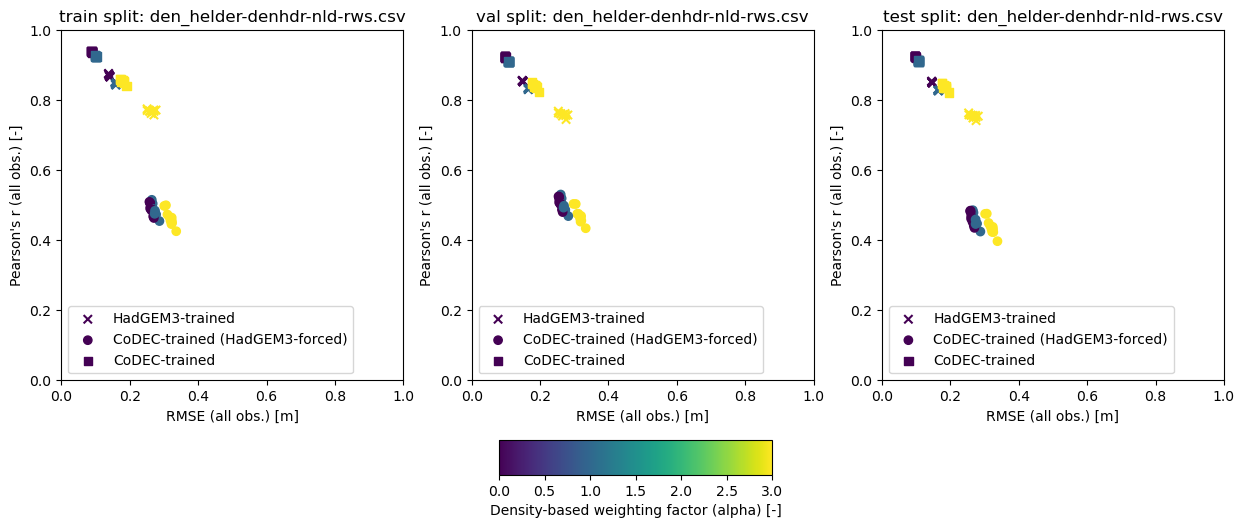

In [11]:
fig=plt.figure(figsize=(15,10))

tg = 'den_helder-denhdr-nld-rws.csv'
out_q = .99


split='train'

ax1 = plt.subplot(2, 3, 1)
s=ax1.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax1.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax1.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax1.colorbar(s)    
ax1.legend()
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('RMSE (all obs.) [m]')
ax1.set_ylabel("Pearson's r (all obs.) [-]")
ax1.set_title(split +' split: '+tg)


split='val'

ax2 = plt.subplot(2, 3, 2)
s=ax2.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax2.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax2.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax2.colorbar(s)    
ax2.legend()
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xlabel('RMSE (all obs.) [m]')
ax2.set_ylabel("Pearson's r (all obs.) [-]")
ax2.set_title(split +' split: '+tg)



split='test'

ax3 = plt.subplot(2, 3, 3)
s=ax3.scatter(ds1.sel(tg=tg).rmse_bulk.sel(split=split),
            ds1.sel(tg=tg).r_bulk.sel(split=split),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax3.scatter(predictions_ds.sel(tg=tg).rmse_bulk.sel(split=split),
            predictions_ds.sel(tg=tg).r_bulk.sel(split=split),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax3.scatter(ds.sel(tg=tg).rmse_bulk.sel(split=split),
            ds.sel(tg=tg).r_bulk.sel(split=split),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax3.colorbar(s)    
ax3.legend()
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.set_xlabel('RMSE (all obs.) [m]')
ax3.set_ylabel("Pearson's r (all obs.) [-]")
ax3.set_title(split +' split: '+tg)



cax=inset_axes(ax2,width="100%", height="100%",bbox_to_anchor=(1.3, -.25,.8,.1),bbox_transform=ax1.transAxes)
fig.colorbar(s, cax=cax,orientation='horizontal',label='Density-based weighting factor (alpha) [-]')


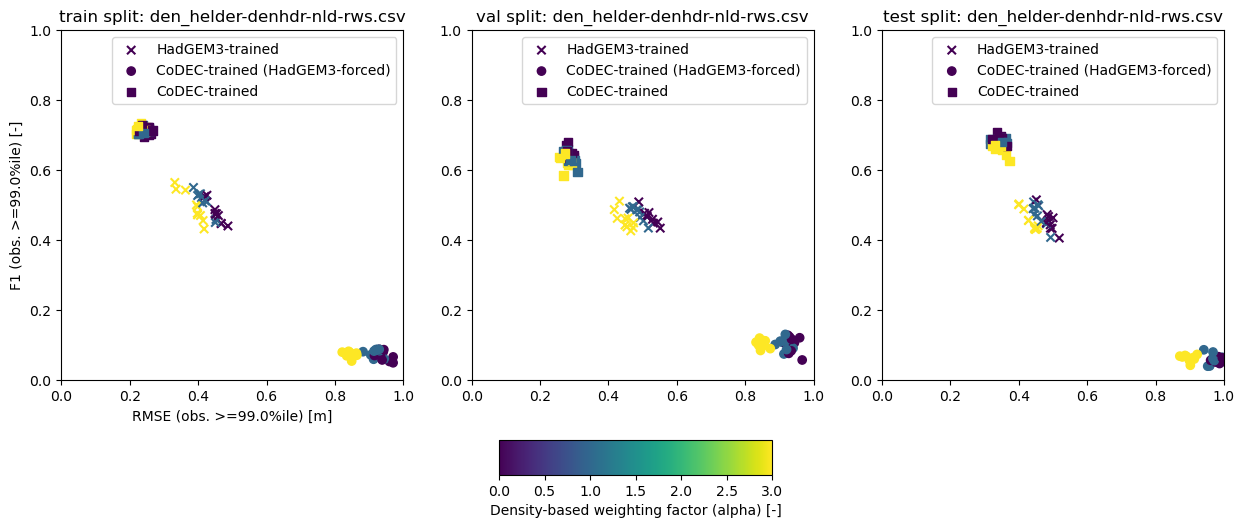

In [12]:
fig=plt.figure(figsize=(15,10))

tg = 'den_helder-denhdr-nld-rws.csv'
out_q = .99


split='train'

ax1 = plt.subplot(2, 3, 1)
s=ax1.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax1.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax1.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax1.colorbar(s)    
ax1.legend()
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax1.set_title(split +' split: '+tg)


split='val'

ax2 = plt.subplot(2, 3, 2)
s=ax2.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax2.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax2.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax2.colorbar(s)    
ax2.legend()
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax2.set_title(split +' split: '+tg)



split='test'

ax3 = plt.subplot(2, 3, 3)
s=ax3.scatter(ds1.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds1.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds1.hyperparameters.sel(tg=tg,split=split,p='dl_alpha'),marker='x',label='HadGEM3-trained')
s=ax3.scatter(predictions_ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            predictions_ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=predictions_ds.hyperparameters.sel(p='dl_alpha'),marker='o',label='CoDEC-trained (HadGEM3-forced)')
s=ax3.scatter(ds.sel(tg=tg).rmse_extremes.sel(split=split,quantile=out_q)/observed_thresholds_codec.sel(tg=tg).sel(quantile=out_q).sel(split=split),
            ds.sel(tg=tg).f1.sel(split=split,quantile=out_q),c=ds.hyperparameters.sel(p='dl_alpha',split=split),marker='s',label='CoDEC-trained')

#ax3.colorbar(s)    
ax3.legend()
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax1.set_xlabel('RMSE (obs. >='+str(100*out_q)+'%ile) [m]')
ax1.set_ylabel('F1 (obs. >='+str(100*out_q)+'%ile) [-]')
ax3.set_title(split +' split: '+tg)



cax=inset_axes(ax2,width="100%", height="100%",bbox_to_anchor=(1.3, -.25,.8,.1),bbox_transform=ax1.transAxes)
fig.colorbar(s, cax=cax,orientation='horizontal',label='Density-based weighting factor (alpha) [-]')
